In [1]:
import pickle
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from collections import Counter
import scipy as sp
import glob

DATA_PATH = os.path.join("..", "data_for_paper_comparison", "minigpt", "openai_fixed")
TEST_ENT_PATH = os.path.join("..", "predictor", "entities_test_openai.txt")
TRAIN_ENT_PATH = os.path.join("..", "predictor", "entities_train_openai.txt")
OUT_DIR_TRAIN = os.path.join("..", "data_for_paper_comparison", "minigpt", "train")
OUT_DIR_TEST = os.path.join("..", "data_for_paper_comparison", "minigpt", "test")
os.makedirs(OUT_DIR_TRAIN, exist_ok=True)
os.makedirs(OUT_DIR_TEST, exist_ok=True)

In [2]:
def create_windows(entry_data, top_k, window_size, stride, logit_key_name = "top_k_probs", label_key_name = "labels"):
    logits = entry_data[logit_key_name][:, -top_k:]
    # Cut labels to remove prompt
    labels = entry_data[label_key_name][-logits.shape[0]:]

    num_windows = ((logits.shape[0] - window_size) // stride) + 1

    # Create windows for the logits based on window size and stride
    logits_windows = np.lib.stride_tricks.sliding_window_view(logits, (window_size, logits.shape[1]))[::stride]
    logits_windows = logits_windows.squeeze(1)

    # Create windows for the labels based on window size and stride
    labels_windows = np.lib.stride_tricks.sliding_window_view(labels, window_size)[::stride]

    assert (num_windows == logits_windows.shape[0])
    assert (num_windows == labels_windows.shape[0])

    return logits_windows, labels_windows

In [3]:
def stitichintime_metric(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.min(relevant_probs)


def do_min_of_max(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.min(np.max(relevant_probs, axis=1))

def max_ent(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.max(sp.stats.entropy(relevant_probs, axis = 1))

def mean_ent(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.mean(sp.stats.entropy(relevant_probs, axis = 1))

In [4]:
# Generate Dataset
def make_data(root_path):
    winsize = 6
    stride = 1
    topk = 20
    
    probs_SIT_metric = []
    #probs_our_metric = []
    all_labels = []
    for i, file_path in enumerate(glob.glob(os.path.join(root_path, "*.pkl"))):
        if i % 100 == 0:
            print(i)
        with open(file_path, "rb") as f:
            data = pandas.read_pickle(f)
    
        logit_windows, labels_windows = create_windows(data, topk, winsize, stride)
    
        data['chosen_token_prob2'] = data['chosen_token_prob'].unsqueeze(1)
        prob_windows, concept_windows = create_windows(data, topk, winsize, stride, logit_key_name="chosen_token_prob2",
                                                        label_key_name='concept_words')
        prob_windows = prob_windows.squeeze(2)
        for probs, labels, concepts, logits in zip(prob_windows, labels_windows, concept_windows, logit_windows):
            probs_SIT_metric.append(stitichintime_metric(probs, concepts))
     #       probs_our_metric.append(do_min_of_max(logits, concepts))
            all_labels.append(1 if 1 in labels else 0)
    
    probs_SIT_metric = np.array(probs_SIT_metric)
   # probs_our_metric = np.array(probs_our_metric)
    all_labels = np.array(all_labels)
    return probs_SIT_metric, all_labels

In [5]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score

for root, name in [(OUT_DIR_TEST, "Test"), (OUT_DIR_TRAIN, "Train")]:
    print(name)
    probs_SIT_metric, all_labels = make_data(root)
    # y_true, y_score
    auc_score = roc_auc_score(all_labels, probs_SIT_metric)
    predictions = [1 if p >= 0.5 else 0 for p in probs_SIT_metric]
    f1_scorezz = f1_score(all_labels, predictions)
    print(f"**** {name}****:\nAUC: {auc_score:.4f}, F1: {f1_scorezz:.4f}")

Test
0
100
**** Test****:
AUC: 0.4407, F1: 0.3253
Train
0
100
200
300
400
500
**** Train****:
AUC: 0.4442, F1: 0.3421


In [7]:
OPT_DATA = os.path.join("..", "data_for_paper_comparison", "OPT", "Test_w_chosen_token_and_concepts")
PYTHIA_DATA = os.path.join("..", "data_for_paper_comparison", "pythia", "Test_w_chosen_token_and_concepts")

In [8]:
def stitichintime_metric2(probs, concepts):
    relevant_probs = probs[concepts == 1]
    if len(relevant_probs) == 0:
        return 1
    return np.min(relevant_probs)


In [14]:
# Generate Dataset
def make_data2(root_path):
    winsize = 6
    stride = 1
    topk = 20
    
    probs_SIT_metric = []
    #probs_our_metric = []
    all_labels = []
    for i, file_path in enumerate(glob.glob(os.path.join(root_path, "*.pkl"))):
        if i % 100 == 0:
            print(i)
        with open(file_path, "rb") as f:
            data = pandas.read_pickle(f)
    
        logit_windows, labels_windows = create_windows(data, topk, winsize, stride)
    
        data['chosen_token_prob2'] = data['chosen_token_prob'].unsqueeze(1)
        prob_windows, concept_windows = create_windows(data, topk, winsize, stride, logit_key_name="chosen_token_prob2",
                                                        label_key_name='concept_words')
        prob_windows = prob_windows.squeeze(2)
        for probs, labels, concepts, logits in zip(prob_windows, labels_windows, concept_windows, logit_windows):

            probs_SIT_metric.append(stitichintime_metric(probs, concepts))
     #       probs_our_metric.append(do_min_of_max(logits, concepts))
            all_labels.append(1 if 1 in labels else 0)
    
    probs_SIT_metric = np.array(probs_SIT_metric)
   # probs_our_metric = np.array(probs_our_metric)
    all_labels = np.array(all_labels)
    return probs_SIT_metric, all_labels

In [ ]:
shape

In [16]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score

for root, name in [(OPT_DATA, "OPT")]:
    print(name)
    probs_SIT_metric, all_labels = make_data2(root)
    # y_true, y_score
    auc_score = roc_auc_score(all_labels, probs_SIT_metric)
    predictions = [1 if p >= 0.5 else 0 for p in probs_SIT_metric]
    f1_scorezz = f1_score(all_labels, predictions)
    print(f"**** {name}****:\nAUC: {auc_score:.4f}, F1: {f1_scorezz:.4f}")

OPT
0
**** OPT****:
AUC: 0.4388, F1: 0.6992


In [17]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score

for root, name in [(PYTHIA_DATA, "Pythia")]:
    print(name)
    probs_SIT_metric, all_labels = make_data2(root)
    # y_true, y_score
    auc_score = roc_auc_score(all_labels, probs_SIT_metric)
    predictions = [1 if p >= 0.5 else 0 for p in probs_SIT_metric]
    f1_scorezz = f1_score(all_labels, predictions)
    print(f"**** {name}****:\nAUC: {auc_score:.4f}, F1: {f1_scorezz:.4f}")

Pythia
0
**** Pythia****:
AUC: 0.4201, F1: 0.7473


In [19]:
# Initialize variables
best_threshold = 0
best_f1 = 0
probs_SIT_metric, all_labels = make_data(OUT_DIR_TRAIN)

# Evaluate thresholds from 0.0 to 1.0
thresholds = np.linspace(0, 1, 101)  # 101 thresholds from 0.0 to 1.0
for threshold in thresholds:
    # Convert probabilities to binary predictions
    predictions = (probs_SIT_metric >= threshold).astype(int)
    
    # Compute F1 score
    f1 = f1_score(all_labels, predictions)
    
    # Update best threshold if the current F1 score is better
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)

0
100
200
300
400
500
Best Threshold: 0.0
Best F1 Score: 0.45343817627664035


In [ ]:
    fpr, tpr, thresholds = roc_curve(all_labels, probs_SIT_metric)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUROC - Chosen Token Probability')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
# Undersampling for balance
np.random.seed(42)
probs_SIT_metric = np.array(probs_SIT_metric)
probs_our_metric = np.array(probs_our_metric)
all_labels = np.array(all_labels)

counter = Counter(all_labels)
min_class_size = min(counter.values())

# Separate truth from hallucination
true_probs_SIT = probs_SIT_metric[all_labels == 0]
hall_probs_SIT = probs_SIT_metric[all_labels == 1]
true_probs_our_metric = probs_our_metric[all_labels == 0]
hall_probs_our_metric = probs_our_metric[all_labels == 1]

# Undersample
true_chosen_indices = np.random.choice(len(true_probs_SIT), min_class_size, replace=False)
hall_chosen_indices = np.random.choice(len(hall_probs_SIT), min_class_size, replace=False)

chosen_true_probs_SIT = true_probs_SIT[true_chosen_indices]
chosen_hall_probs_SIT = hall_probs_SIT[hall_chosen_indices]

chosen_true_probs_our_metric = true_probs_our_metric[true_chosen_indices]
chosen_hall_probs_our_metric = hall_probs_our_metric[hall_chosen_indices]

chosen_true_labels = np.zeros(min_class_size)
chosen_hall_labels = np.ones(min_class_size)


probs_SIT_metric = np.concatenate((chosen_true_probs_SIT, chosen_hall_probs_SIT), axis=0)
probs_our_metric = np.concatenate((chosen_true_probs_our_metric, chosen_hall_probs_our_metric), axis=0)
all_labels = np.concatenate((chosen_true_labels, chosen_hall_labels), axis=0)
print("done")

done


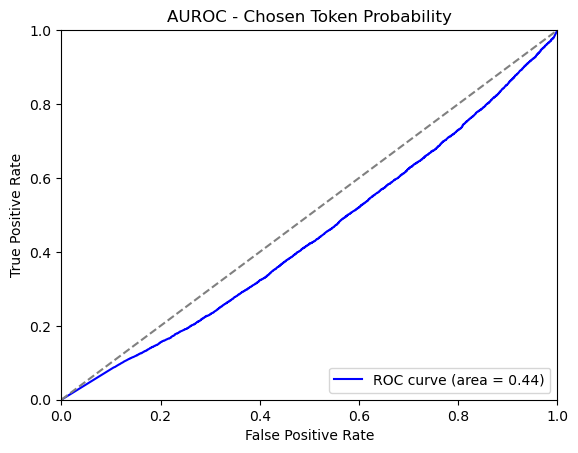

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, probs_SIT_metric)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC - Chosen Token Probability')
plt.legend(loc="lower right")
plt.show()

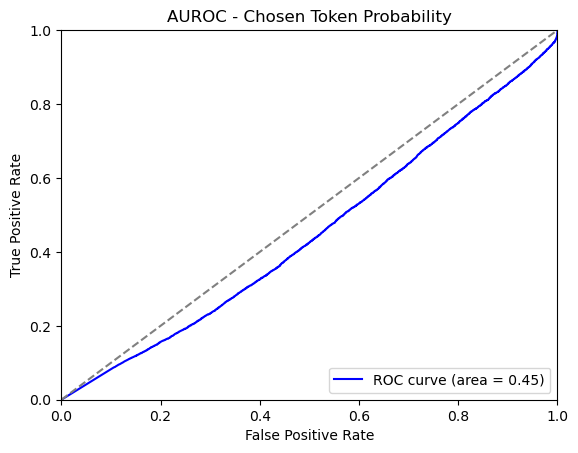

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, probs_our_metric)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC - Chosen Token Probability')
plt.legend(loc="lower right")
plt.show()

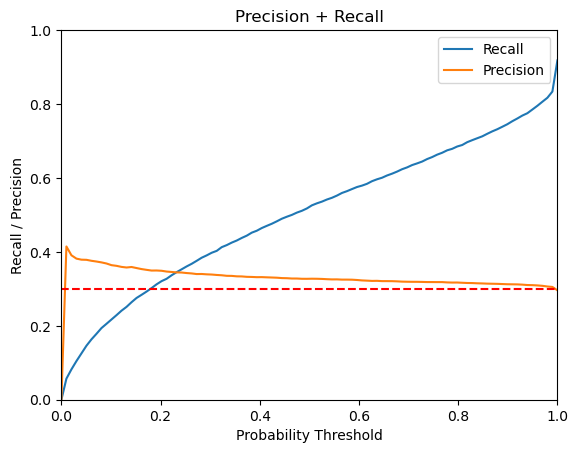

0.3014606912261908


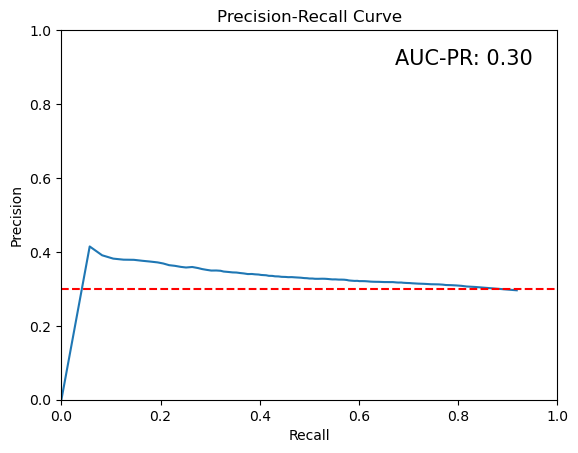

In [11]:
# Calculate AUC


threshold_array = np.linspace(0, 1, 100)
accuracies = np.zeros(len(threshold_array))
recalls = np.zeros(len(threshold_array))
precisions = np.zeros(len(threshold_array))


for i, thresh in enumerate(threshold_array):
    hallucinations = probs_SIT_metric < thresh

    accuracy = np.sum(hallucinations == all_labels) / len(all_labels)
    accuracies[i] = accuracy
    if np.sum(all_labels) != 0:
        recall = np.sum(hallucinations * all_labels) / np.sum(all_labels)
        recalls[i] = recall
    if np.sum(hallucinations) != 0:
        precision = np.sum(hallucinations * all_labels) / np.sum(hallucinations)
        precisions[i] = precision
    

plt.plot(threshold_array, recalls, label='Recall')
plt.plot(threshold_array, precisions, label = 'Precision')
plt.xlabel('Probability Threshold')
plt.ylabel('Recall / Precision')
plt.legend()
plt.title("Precision + Recall")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(y=0.3, linestyle='--', color='red')
plt.show()

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
auc_pr = auc(recalls, precisions)
print(auc_pr)
plt.text(0.95, 0.95, f'AUC-PR: {auc_pr:.2f}',
         fontsize=15, ha='right', va='top', transform=plt.gca().transAxes) 
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(y=0.3, linestyle='--', color='red')
plt.show()

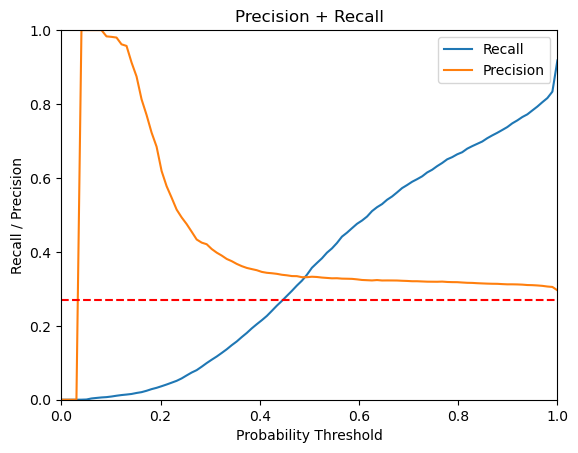

0.3300418673360616


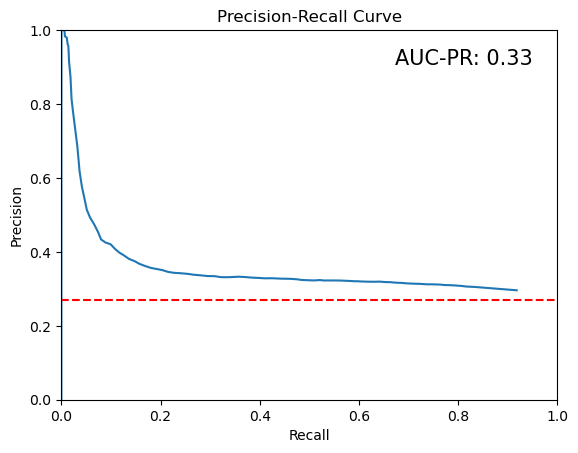

In [12]:
# Calculate AUC
threshold_array = np.linspace(0, 1, 100)
accuracies = np.zeros(len(threshold_array))
recalls = np.zeros(len(threshold_array))
precisions = np.zeros(len(threshold_array))


for i, thresh in enumerate(threshold_array):
    hallucinations = probs_our_metric < thresh

    accuracy = np.sum(hallucinations == all_labels) / len(all_labels)
    accuracies[i] = accuracy
    if np.sum(all_labels) != 0:
        recall = np.sum(hallucinations * all_labels) / np.sum(all_labels)
        recalls[i] = recall
    if np.sum(hallucinations) != 0:
        precision = np.sum(hallucinations * all_labels) / np.sum(hallucinations)
        precisions[i] = precision

plt.plot(threshold_array, recalls, label='Recall')
plt.plot(threshold_array, precisions, label = 'Precision')
plt.xlabel('Probability Threshold')
plt.ylabel('Recall / Precision')
plt.legend()
plt.title("Precision + Recall")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(y=0.27, linestyle='--', color='red')
plt.show()

plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
auc_pr = auc(recalls, precisions)
print(auc_pr)
plt.text(0.95, 0.95, f'AUC-PR: {auc_pr:.2f}',
         fontsize=15, ha='right', va='top', transform=plt.gca().transAxes) 
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(y=0.27, linestyle='--', color='red')
plt.show()